GOAL: Identify text fields that could be turned into more quantifiable data for analysis.  

SUMMARY: Some of the fields in the dataset have valuable information in them, but because that information is contained in unstructured data (e.g. information that is not arranged according to a pre-set data model or schema, in this case, text fields obtained from open ended questions in surveys).  This effort will attempt to use an NLP summarization approach to turn those 

STEPS:
1. Identify the fields available, pick one! - DONE
2. Identify categories related to a field that are useful to a clinician doing research/analysis - DONE
3. Do sentiment analysis on each row, using that score as a new score to use as a datapoint - DONE
4. Use cosine similiarity to see how similar those numbers are to the overall cognitive score as an additional exercise.
5. Also look at correlation / covariance - DONE

In [1]:
# need an offline local version of plotly to use that library:
import sys 
!{sys.executable} -m pip install plotly

In [2]:
import pandas as pd
import numpy as np

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download([
    "maxent_ne_chunker", 
    "vader_lexicon",
])

from sklearn.metrics.pairwise import cosine_similarity

# graphics
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /opt/conda/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /opt/conda/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
pd.__version__

'1.2.3'

In [4]:
# datasets with text fields
cslb_df = pd.read_csv("CSV_DATA/DAP_2020_CSLB_v1.1.csv")
ownr_df = pd.read_csv("CSV_DATA/DAP_2020_HLES_dog_owner_v1.1.csv")
cncr_df = pd.read_csv("CSV_DATA/DAP_2020_HLES_cancer_condition_v1.1.csv")

In [5]:
# Look at CSLB first:
pd.set_option('display.max_rows', None)
first_row_df = cslb_df.iloc[1] # .tolist()
first_row_df
# for cslb_df -> cslb_other_changes 

dog_id                                                            54147
cslb_active_6mo                                                       3
cslb_avoid                                                            5
cslb_date                                                    2020-11-09
cslb_defecate_6mo                                                     3
cslb_find_food                                                        1
cslb_food_6mo                                                         3
cslb_other_changes    During the past several weeks he has displayed...
cslb_pace                                                             1
cslb_pace_6mo                                                         3
cslb_recognize                                                        1
cslb_recognize_6mo                                                    3
cslb_score                                                           38
cslb_stare                                                      

In [6]:
# Look at Owner fields:
pd.set_option('display.max_rows', None)
first_row_df = ownr_df.iloc[0] # .tolist()
first_row_df
# for owner db -> hs_other_medical_info 

owner_id                                                                                                        1
oc_household_adult_count                                                                                        2
oc_household_child_count                                                                                        0
oc_household_person_count                                                                                       2
oc_primary_residence_census_division                                                                          9.0
oc_primary_residence_ownership                                                                                  2
oc_primary_residence_ownership_other_description                                                              NaN
oc_primary_residence_state                                                                                     WA
oc_primary_residence_time_percentage                                                    

In [7]:
# Look at Cancer fields:
pd.set_option('display.max_rows', None)
first_row_df = cncr_df.iloc[0] # .tolist()
first_row_df
# for cncr_df -> hs_cancer_locations_other_description, hs_cancer_types_other_description 

dog_id                                                           29702
hs_cancer_locations_adrenal_gland                                False
hs_cancer_locations_anal_sac                                     False
hs_cancer_locations_bladder_or_urethra                           False
hs_cancer_locations_blood                                        False
hs_cancer_locations_bone_or_joint                                False
hs_cancer_locations_brain                                        False
hs_cancer_locations_cardiac_tissue                               False
hs_cancer_locations_ear                                          False
hs_cancer_locations_esophagus                                    False
hs_cancer_locations_eye                                          False
hs_cancer_locations_gallbladder_or_bile_duct                     False
hs_cancer_locations_gastrointestinal_tract                       False
hs_cancer_locations_kidney                                       False
hs_can

Found these text fields in these tables for potential summarization:
- for cslb_df -> cslb_other_changes
- for owner db -> hs_other_medical_info 
- for cncr_df -> hs_cancer_locations_other_description, hs_cancer_types_other_description

Planning to use the cslb_other_changes from the CSLB survey-related data set.

This field originates in the Canine Social and Learned Behavior Survey (CSLB).  This survey is intended to assess age-related cognitive and behavioral changes in the dog participants.  The data set we are using only has one entry per dog owner that participated (20,096 of the 27,541 participating dog owners), but is intended to be filled in longitudinally (annually each August).  As this new data is acquired, this field becomes increasingly important in assessing the cognitive and behavioral changes in the participating dogs.  But of course, the challenge is that because it is entered in an unstructured open-ended text-based way, it is more difficult to quantify and utilize in analysis than other fields in the survey that are mostly numerical/categorical in nature.  

The specific question that is asked to result in this field's data is:
"In the last 6 months, have you observed any other changes in your dog's thinking or information processing that you want to share with us?"

Lets look closer at this field to see what it is telling us.

In [8]:
# clean out non answers
pd.set_option("display.max_colwidth", -1) # display the full text of the column
print('pre-clean size: ',len(cslb_df))
dropna_df = cslb_df.dropna(subset=['cslb_other_changes'])
dropna_df.drop(dropna_df.index[dropna_df['cslb_other_changes'] == 'no'], inplace=True)
dropna_df.drop(dropna_df.index[dropna_df['cslb_other_changes'] == 'No'], inplace=True)
dropna_df.drop(dropna_df.index[dropna_df['cslb_other_changes'] == 'No.'], inplace=True)
dropna_df.drop(dropna_df.index[dropna_df['cslb_other_changes'] == 'None'], inplace=True)
dropna_df.drop(dropna_df.index[dropna_df['cslb_other_changes'] == 'no changes'], inplace=True)
dropna_df.drop(dropna_df.index[dropna_df['cslb_other_changes'] == 'not really.'], inplace=True)
print('post-clean size: ',len(dropna_df))

text_field = dropna_df[['dog_id', 'cslb_active_6mo', 'cslb_avoid', 'cslb_defecate_6mo', 'cslb_other_changes']]
# text_field.sample(20) # [0:200]
dropna_df.sample(5)

# hidden because of the dog names in the fields

pre-clean size:  20096
post-clean size:  10251


,dog_id,cslb_active_6mo,cslb_avoid,cslb_date,cslb_defecate_6mo,cslb_find_food,cslb_food_6mo,cslb_other_changes,cslb_pace,cslb_pace_6mo,cslb_recognize,cslb_recognize_6mo,cslb_score,cslb_stare,cslb_stare_6mo,cslb_stuck,cslb_walk_walls
3558,58163,3,1,2020-11-30,3,1,3,I haven't noticed any change.,3,3,1,3,36,1,3,1,1
14290,47953,4,1,2020-11-23,3,1,3,"Leo has definitely lost more mobility in his hind legs. He had a hip replacement at a young age and blew out his knee two summers ago. I believe the lack of stability from his knee is more of the mobility issue as well as arthritis. He is on pain meds daily. He definitely does not always attempt to get up on our hardwood floors, he will bark or whine if he needs help getting up . This is the only thing that has changed in regards to his thinking. He knows when he needs help up and it is not all the time but more so when he is only on hardwood with no mat. I also believe his hearing is diminishing -if you are standing behind him he doesn't always hear when you call his name or approach. I don't notice any cognitive decline. His personality and vocal behaviors haven't changed one bit.",1,3,1,3,35,1,3,1,1
8135,32412,3,1,2020-11-05,3,1,3,behaves the same as 6 months ago,1,3,1,3,35,1,3,2,1
14517,91984,4,1,2020-12-12,3,1,3,"Giovanni has unlimited access outside and uses a doggie door. Within the past few months, even though he has just gone outside, he will come inside and suddenly turn around and run back outside. Initially we thought that maybe he had to relieve himself or wasn't feeling well. As we continued to observe him, to see what he was doing with such urgency to run immediately back outside, we saw that he would just go outside and stand out there without any agenda or purpose.",1,3,1,3,35,1,3,1,1
14864,14344,2,1,2020-11-04,3,1,3,"Yeti has begun to knuckle his front legs, more so on the right",1,3,1,3,33,1,3,1,1


Oh oh.  There are dog names in these fields!  Those were supposed to be removed when they anonymized the data.  We could easily address this by running a named entity recognition algorithm from NLTK library.  

In [9]:
# find all the people
for index, row in text_field.iterrows():
    text = row['cslb_other_changes']
    for sent in nltk.sent_tokenize(text):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if hasattr(chunk, 'label'):
                if chunk.label() == 'PERSON':
                    # write code to pull out the PERSON name
                    for name in chunk:
                        text2 = text.replace(name[0], "DOG_NAME_REDACTED")
                        text_field.at[index, 'cslb_other_changes'] = text2

text_field.head(5)

,dog_id,cslb_active_6mo,cslb_avoid,cslb_defecate_6mo,cslb_other_changes
1,54147,3,5,3,During the past several weeks he has displayed a reluctance to go up or down any stairs. I assist him with patience and compassion in managing the stairs in order to work through this new issue.
7,58831,4,1,3,"""We lost our chocolate lab in mid-April, which has affected how much time DOG_NAME_REDACTED is active. She also appears """"sad"""" by her sprawling on floor and looking up dejected. Might be anthropomorphic but still it best describes what I see. """
8,80304,1,1,1,"When DOG_NAME_REDACTED is being walked on leash and we come upon either a stranger or a familiar person, I am able to retain his attention upon me or have him settle quietly while the person and I talk. If, however, he is off-leash in our yard for a potty break and someone is walking on the street, whether known or unknown, he races towards them barking, and it is sometimes difficult getting him to break off and return home, especially if the person continues to walk away. There is nothing wrong with his eyesight, as he is able quite easily to spot people walking dogs, jogging, deer in the yard, the black cat on the driveway, or squirrels in the tree."
9,51443,3,1,3,"He was a rescue and had trust issues. He is trusting other people more, but is still aggressive with other dogs which we are working on."
10,29702,5,5,3,"Mandy has developed a needy type of attitude in the last 6 months. If I am at my computer, she will take her nose and put it under my knee telling me to get up. She will either lead me to the kitchen - look at her bowl then the fridge OR take me to the door to go out. She is also getting up in the wee hours and will put her nose close to your head (while sleeping) and either snort or cry until you get up. She also has become super attached and does not like me leaving her alone. She gets depressed and mopey if I leave for too long. I try to have someone at home with her at all times."


Ok, we took out the names, phew!  We will send a note back to the data curators with this code so that they can make the data more anonymous.  

Now lets focus on adding some quantitative value based on this text field.  There are a variety of approaches we could take.  With more time, we could do some qualitative research, talking with veterinary clinicians, to get a better idea of what kind of data would be the most valuable from a research standpoint.  Perhaps they could be labeled into categories that indicate health issues mentioned in the text, possibly even with a severity value.  This could be labeled with actual humans using veterinary clinicians, probably with multiple people looking at each row to see how well they agree on the label and value.  We could avoid having to have them do all 20,096 fields by using a semi-supervised approach that fills in the labels on unlabelled data based on the first few thousand labels.  It may be valuable to use the human labelers to provide a value specific to cognitive capabalities, since that was the original purpose of this data set. There seems to be a lot of potential here with the right approach.  For now though, we plan to run a simple sentiment analysis on the text fields that give us a sentiment value that aligns with the positivity/negativity of the text.  

I am using the pre-trained VADER (Valence Aware Dictionary and senEntiment Reasoner), which is a built-in sentiment analyzer in the NLTK library.  VADER is considered best suited for language used in less formal text environments, like social media and other text with short sentences with some slang and abbreviations.  It is less accurate when rating longer, structured sentences.  The text we are analyzing here is less formal though, so this should work for us generally.

In [10]:
# assuming if person actually answers "no" (or something similar) or if it is left blank, 
#   it is neutral for the sentiment score
sia = SentimentIntensityAnalyzer()

cslb_df['sentiment'] = 0.0

skip_wds = ['no', 'No', 'No.', 'None', 'no changes']

for index, row in cslb_df.iterrows():
    text = row['cslb_other_changes']
    if text!=text: # checks for nan
        row['sentiment'] = 0
    elif text in skip_wds:
        row['sentiment'] = 0
    else:
        comp_score = float(sia.polarity_scores(text)["compound"])
        cslb_df.at[index, 'sentiment'] = float(comp_score)
    
cslb_df.sample(10)

,dog_id,cslb_active_6mo,cslb_avoid,cslb_date,cslb_defecate_6mo,cslb_find_food,cslb_food_6mo,cslb_other_changes,cslb_pace,cslb_pace_6mo,cslb_recognize,cslb_recognize_6mo,cslb_score,cslb_stare,cslb_stare_6mo,cslb_stuck,cslb_walk_walls,sentiment
15207,14883,3,1,2020-11-14,3,1,3,NaN,1,3,1,3,34,1,3,1,1,0.0000
13699,60701,3,1,2020-11-06,3,2,3,NaN,1,3,1,3,35,1,3,1,1,0.0000
12126,1997,2,1,2020-11-25,3,1,3,"No, he is lively and alert; still going strong at 9.5 years. He is a total delight.",1,3,1,3,33,1,3,1,1,0.8779
5715,48061,2,4,2020-11-05,2,2,3,My dog was a mill dog rescue up until the age of six. It took him about a year to make any barking sounds. Now he is very protective while in the house however he stops aggression and barking while outside. He does not like to be outside because of the noises of people and cars. He is in sheer panic and anxiety mode constantly while outside in the yard. He paces a lot less than when we first adopted him. Although he mostly stays to himself during the day he does play in the evening. He is easy to train but still cannot get him to go outside on his own or by himself. He's more comfortable in the mountains where there are not a lot of noises. He is food driven and plays with dog interaction toys to find treats.,5,2,1,2,36,1,3,1,1,0.8039
5902,4042,3,1,2020-11-04,3,1,3,NaN,1,3,1,1,28,1,3,1,1,0.0000
8189,70321,3,1,2020-11-15,3,1,3,NaN,1,3,1,3,34,1,3,1,1,0.0000
20071,5452,3,1,2020-11-14,3,1,3,"Ridley's information processing has greatly IMPROVED--probably a combination of age, going from 18 mo to 2yo, and formal training--off leash-follows commands now.",1,3,1,3,38,5,3,1,1,0.0000
8876,3365,3,2,2020-11-15,4,1,3,I haven't really noticed any changes in Button.,1,3,2,3,37,1,3,1,1,0.0000
16601,6795,4,4,2020-11-17,3,2,3,NaN,2,3,1,3,41,2,3,1,1,0.0000
19885,3687,3,1,2020-11-04,3,1,3,No,1,3,1,3,36,3,3,1,1,0.0000


We will also take that value and compare it to the cognitive score provided in the data set using covariance similarity. This score is meant to be the best representative of each dog participant's current cognitive status, and therefore, it would interesting to look at the covariance and correlation between to cognitive score and the sentiment of the text.

In [11]:
# pull out the values that we will use to make it a little easier to call across all the functions
cslbscores = cslb_df['cslb_score']
sentscores = cslb_df['sentiment']

In [12]:
# Product Scores
print(cslbscores.mean())
fig = px.histogram(cslb_df, x="cslb_score")
fig.update_traces(marker_color="turquoise",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Total Scores')
fig.show()

35.65724522292994


In [13]:
# cosine
cosine_similarity([cslbscores], [sentscores])

array([[0.11015703]])

Not very similar, just 0.1102 for cosine similarity, so slightly positively similar.

In [14]:
# covariance:
def covariance(x, y):
    # Finding the mean of the series x and y
    mean_x = sum(x)/float(len(x))
    mean_y = sum(y)/float(len(y))
    # Subtracting mean from the individual elements
    sub_x = [i - mean_x for i in x]
    sub_y = [i - mean_y for i in y]
    numerator = sum([sub_x[i]*sub_y[i] for i in range(len(sub_x))])
    denominator = len(x)-1
    cov = numerator/denominator
    return cov

cov_func = covariance(cslbscores, sentscores)
print("Covariance from the custom function:", cov_func)

Covariance from the custom function: -0.1320968954888545


Slightly negative value  indicates that both variables move in slightly opposite directions.

In [15]:
# correlation
def correlation(x, y):
    # Finding the mean of the series x and y
    mean_x = sum(x)/float(len(x))
    mean_y = sum(y)/float(len(y))
    # Subtracting mean from the individual elements
    sub_x = [i-mean_x for i in x]
    sub_y = [i-mean_y for i in y]
    # covariance for x and y
    numerator = sum([sub_x[i]*sub_y[i] for i in range(len(sub_x))])
    # Standard Deviation of x and y
    std_deviation_x = sum([sub_x[i]**2.0 for i in range(len(sub_x))])
    std_deviation_y = sum([sub_y[i]**2.0 for i in range(len(sub_y))])
    # squaring by 0.5 to find the square root
    denominator = (std_deviation_x*std_deviation_y)**0.5 # short but equivalent to (std_deviation_x**0.5) * (std_deviation_y**0.5)
    cor = numerator/denominator
    return cor

cor_func = correlation(cslbscores, sentscores)
print("Correlation from the custom function:", cor_func)

Correlation from the custom function: -0.08305405824380022


Correlation score indicates that it is slightly negative correlation/relationship.  

Text(0, 0.5, 'sent')

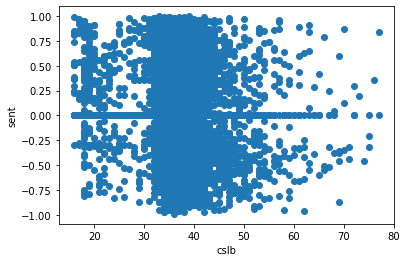

In [16]:
# plot to see how these columns relate to each other (covariance)
import matplotlib.pyplot as plt
plt.scatter(cslbscores, sentscores)
plt.xlabel('cslb')
plt.ylabel('sent')
# doesn't look that related!

In [17]:
# covariance score
np.cov(cslbscores, sentscores)

array([[24.88465315, -0.1320969 ],
       [-0.1320969 ,  0.10165574]])

Pearson Correlation Coefficient — captures the strength and direction of the linear association between two continuous variables
Spearman’s Rank Correlation Coefficient—determines the strength and direction of the monotonic relationship which exists between two ordinal (categorical) or continuous variables.

In [18]:
cslb_df[['cslb_score','sentiment']].corr() 

,cslb_score,sentiment
cslb_score,1.000000,-0.083054
sentiment,-0.083054,1.000000
